## B3. MODIS - Standard deviation, average, index of dispertion calculation (bad results, highly computationally exhoausting)

### 0. Load required libraries,  area dependant constants and utility functions:

In [10]:
from os import listdir
from os.path import isfile, join
import numpy as np

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

import scipy.ndimage as ndimage

### 1. Set up EOTasks for EuclideanNorm production

In [12]:

# index of dispertion is like a normalized variance, thnaks to that, the high magnitude values are not priviledged. 

def index_of_disp(values):
    var = values.var()
    avg = np.average(values)
    return var/avg

# simple function for testing
def std_func(values):
    return values.std()

# simple function for testing
def avg_func(values):
    return np.average(values)

class StandardDeviationCalculation(EOTask):   
    """
    The tasks calculated and appends timeless mask in form of a frame around the picture in order to exclude
    The pixels without properly calculated feature, bc of missing neighbours. 
     """
    def __init__(self, in_feature_name, out_feature_name, out_mask_name, n_range):
        self.in_feature_name = in_feature_name
        self.out_feature_name = out_feature_name
        self.out_mask_name = out_mask_name
        self.n_range = n_range
    
    def execute(self, eopatch):
        # get image shape
        arr = eopatch.data[self.in_feature_name]
        image_shape = arr.shape
        
        # save timeless mask
        mask = np.full(image_shape, False) # create a mask with the image's shape         
        mask[:,self.n_range:-self.n_range,self.n_range:-self.n_range,:] = True # set range with proper data.
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.out_mask_name, mask[-1]) # save mask
        
        #calculate standard deviation
        window = (1,2*self.n_range+1,2*self.n_range+1,1) # # create a window
        results= ndimage.generic_filter(arr, std_func, size=window, mode='constant')
        # masked_result = result * mask # not necessary, as the mask will exclude all in filtering phase 
        eopatch.add_feature(FeatureType.DATA, self.out_feature_name, results )
        return eopatch
       


In [ ]:
# creating eo task calculating EuclideanNorm of all raw bands of ea patches
calculate_std_nbr_3_eotask = StandardDeviationCalculation( 'MODIS_RAW_BANDS', 'MODIS_STD_NBR_3','MODIS_MASK_STD_NBR_3', 3) 

for date_range_modis in site.DATE_RANGES_MODIS:
    print('Reading EOPatches from:', date_range_modis )
    eopatches_filepath = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[0], site.SITE_NAME, site.AVAILABLE_CRSs[0], date_range_modis)
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(eopatches_filepath)
    save_eotask = SaveTask(eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    calculate_std_nbr_3_eotask,
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    execution_args = []
    for eopatch_name in list_of_available_patches:
        execution_args.append({
        load_eotask: {'eopatch_folder': eopatch_name},
        save_eotask: {'eopatch_folder': eopatch_name}
        })
                                       
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=1, multiprocess=False)

    executor.make_report()
    break

Reading EOPatches from: ('2013-04-26', '2013-11-05')


In [2]:
# checking exemplary data:
exemplary_eopatch = EOPatch.load('../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2013_04-2013_11/2969_maxcc_0.05_x-3_y-130')

In [3]:
arr = exemplary_eopatch.data['MODIS_RAW_BANDS']
image_shape = arr.shape

In [4]:
image_shape

(194, 333, 333, 7)

In [6]:
# save timeless mask
n_range = 1
mask = np.full(image_shape, False) # create a mask with the image's shape         
mask[:,n_range:-n_range,n_range:-n_range,:] = True # set range with proper data.
#eopatch.add_feature(FeatureType.MASK_TIMELESS, self.out_mask_name, mask[-1]) # save mask

In [8]:
#calculate standard deviation
window = (1,2*n_range+1,2*n_range+1,1) # # create a window
print(window)

(1, 3, 3, 1)


In [13]:
results= ndimage.generic_filter(arr, std_func, size=window, mode='constant')

In [15]:
results.shape

(194, 333, 333, 7)

execution took 1 h, for the minimum n_range

In [17]:
import matplotlib.pyplot as plt

2013-06-15 12:00:00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

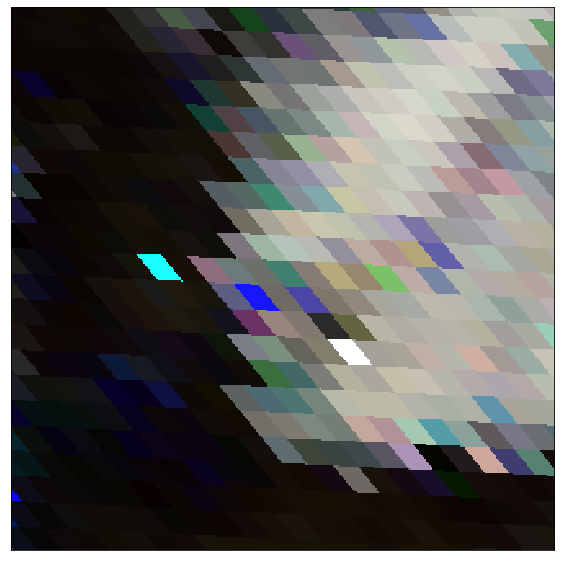

In [18]:
fig = plt.figure(figsize=(10, 10))
print(exemplary_eopatch.timestamp[50])
plt.imshow(exemplary_eopatch.data['MODIS_RAW_BANDS'][50][..., [0, 3, 2]].squeeze())
plt.xticks([])
plt.yticks([])

2013-06-15 12:00:00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

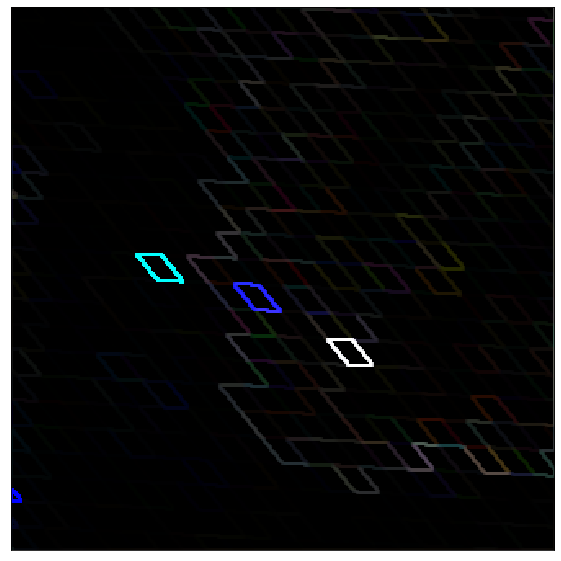

In [19]:
fig = plt.figure(figsize=(10, 10))
print(exemplary_eopatch.timestamp[50])
plt.imshow(results[50][..., [0, 3, 2]].squeeze())
plt.xticks([])
plt.yticks([])

In [20]:
import seaborn as sns

In [27]:
results[50][0].shape

(333, 7)

In [36]:
results[..., [0]].shape

(194, 333, 333, 1)

In [37]:
results[..., [0]].reshape(194* 333* 333)

array([0.3902187, 0.370194 , 0.370194 , ..., 1.5446512, 1.5446512,
       1.6282053], dtype=float32)

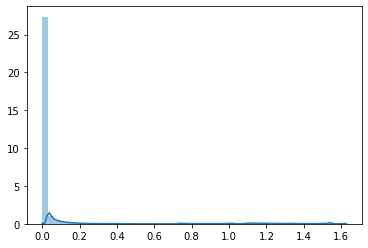

In [38]:
sns.distplot(results[..., [0]].reshape(194* 333* 333))

From what we can see here, n_range is too low. Probably n_range =5 should be better, the best would be 10, 20, but it is impossible due to the computation power,
What is to improve: Maybe code is not efficient,Maybe it has to be done on the data that is not upsampled in the first place 
For now, abort!